In [1]:
%matplotlib inline
from sklearn import datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target

In [3]:
N,D = X.shape
mean = np.mean(X, axis=0)
cov = np.cov(X.T)
mean, cov

(array([5.84333333, 3.05733333, 3.758     , 1.19933333]),
 array([[ 0.68569351, -0.042434  ,  1.27431544,  0.51627069],
        [-0.042434  ,  0.18997942, -0.32965638, -0.12163937],
        [ 1.27431544, -0.32965638,  3.11627785,  1.2956094 ],
        [ 0.51627069, -0.12163937,  1.2956094 ,  0.58100626]]))

In [4]:
n_dim = L = 2
e_values, e_vectors = np.linalg.eigh(cov)
e_values = np.flip(e_values)
e_vectors = np.flip(e_vectors, axis=1)
e_vectors, e_values

(array([[-0.36138659,  0.65658877,  0.58202985,  0.31548719],
        [ 0.08452251,  0.73016143, -0.59791083, -0.3197231 ],
        [-0.85667061, -0.17337266, -0.07623608, -0.47983899],
        [-0.3582892 , -0.07548102, -0.54583143,  0.75365743]]),
 array([4.22824171, 0.24267075, 0.0782095 , 0.02383509]))

In [5]:
V = e_vectors[:, :n_dim]
Lambda = np.diag(e_values[:n_dim])
V, Lambda

(array([[-0.36138659,  0.65658877],
        [ 0.08452251,  0.73016143],
        [-0.85667061, -0.17337266],
        [-0.3582892 , -0.07548102]]),
 array([[4.22824171, 0.        ],
        [0.        , 0.24267075]]))

In [6]:
sigma = 1 / (D - L) * np.sum(e_values[L+1:])
sigma_I = sigma*np.eye(L)

W = V.dot(np.sqrt(Lambda - sigma_I))

M = W.T.dot(W) + sigma_I

In [7]:
def project(X, mean, M_inv, W, sigma):
    new_mean = M_inv.dot(W.T).dot((X - mean).T).T
#     new_sigma = sigma*M_inv
#     z = np.random.multivariate_normal(new_mean, new_sigma, 1)[0]
    return new_mean # retornando apenas a experança

M_inv = np.linalg.inv(M)
z = project(X, mean, M_inv, W, sigma)
z.shape

(150, 2)

In [8]:
def reconstruct(z, mean, W, sigma):
    new_mean = W.dot(z.T).T + mean
#     x = np.random.multivariate_normal(new_mean, sigma*np.eye(D), 1)[0]
    return new_mean

x = reconstruct(z, mean, W, sigma)
x[0]

array([5.07547401, 3.50532148, 1.4124142 , 0.21742624])

In [9]:
np.abs(X[0] - x[0])

array([0.02452599, 0.00532148, 0.0124142 , 0.01742624])

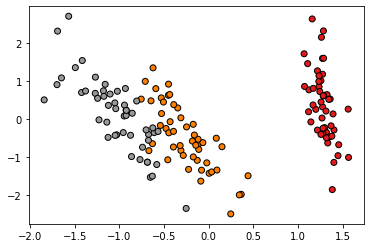

In [10]:
X_projected = project(X, mean, M_inv, W, sigma)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')

In [11]:
def space_likelihood(z, X, mean, M_inv, W, sigma):
    means = M_inv.dot(W.T).dot((X - mean).T).T
    new_sigma = sigma*M_inv
    
    s = 0
    for x, m in zip(X, means):
        s += multivariate_normal.pdf(z, mean=m, cov=new_sigma)
    
    return s
    
space_likelihood(X_projected[0], X, mean, M_inv, W, sigma)

96.63216460530208

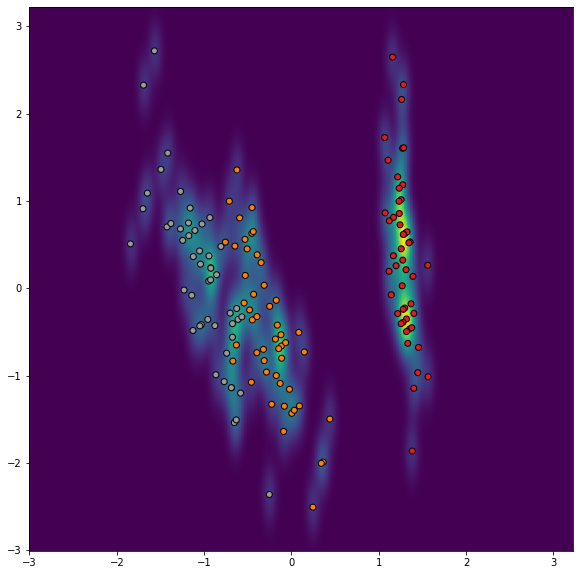

In [12]:
resolution = 200
margin = 0.5
x = y = np.linspace(X_projected.min()-margin,X_projected.max()+margin,resolution)
grid = np.dstack(np.meshgrid(x,y)).reshape(-1,2)

densities = np.array([space_likelihood(x, X, mean, M_inv, W, sigma) for x in tqdm(grid)]).reshape(resolution, resolution)
plt.figure(figsize=(10,10))
plt.imshow(densities, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')

### Comparando com o PCA do sklearn

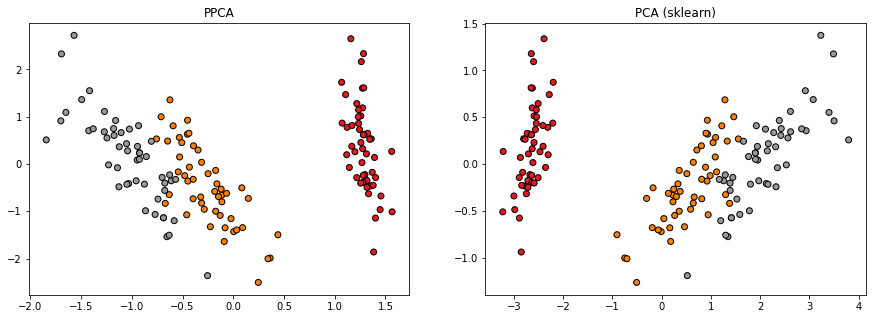

In [13]:
from sklearn.decomposition import PCA

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
X_projected = np.array([project(x, mean, M_inv, W, sigma) for x in X])
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.title("PPCA")

plt.subplot(1,2,2)
pca = PCA(n_components=2)
X_projected = pca.fit(X).transform(X)

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
_ = plt.title("PCA (sklearn)")

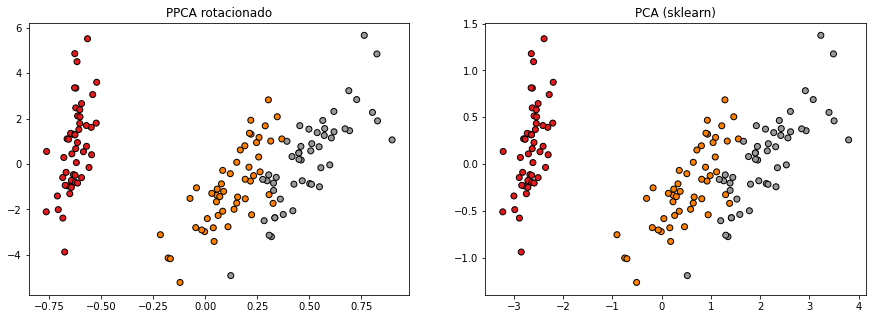

In [14]:
# estimando matriz de rotação
R = np.linalg.inv(W.T.dot(W)).dot(W.T).dot(pca.components_.T)

X_rot = project(X, mean, M_inv, W, sigma).dot(R)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(X_rot[:, 0], X_rot[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
_ = plt.title(f"PPCA rotacionado")

plt.subplot(1,2,2)
X_projected = pca.fit(X).transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
_ = plt.title("PCA (sklearn)")

## EM

(array([[-1.23046432,  4.83532625],
        [ 2.46858377,  3.41930465],
        [-7.18556121,  2.55552819],
        [-3.01258017,  1.0535148 ]]),
 0.05502044798973423,
 array([[0.01671309, 0.00743397],
        [0.00743397, 0.02670285]]))

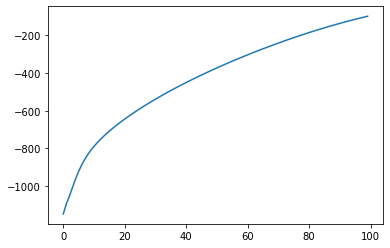

In [15]:
def log_likelihood(X, mean, W, M_inv, sigma):
    s = 0
    for x in X:
        z =  M_inv.dot(W.T).dot((x - mean))
        
        v = (D/2)*np.log(2*np.pi*sigma) + (n_dim/2)*np.log(2*np.pi) + 0.5*np.trace(np.outer(z,z))
        v += (1/(2*sigma))*np.linalg.norm(x - mean)**2 - (1/sigma)*W.dot(z).dot(x-mean)
        v += 1/(2*sigma)*np.trace(np.outer(z,z).dot(W.T).dot(W))
        
        s -= v
        
    return s
    
def fit(X, mean, W_0, sigma_0, iter=10, debug=False):
    
    W = W_0.copy()
    sigma = sigma_0
    M_inv = None
    
    log_likelihoods = []
    
    for i in range(iter):
        M_inv = np.linalg.inv(W.T.dot(W) + sigma*np.eye(n_dim))

        e_z = M_inv.dot(W.T).dot((X - mean).T)
        e_zz = sigma*M_inv + e_z.dot(e_z.T)
        
        W = ((X - mean).T.dot(e_z.T)).dot(np.linalg.inv(e_zz))
        
        s = 0
        for i,x in enumerate(X):
            e_zi = e_z[:,i]
            e_zzi = sigma*M_inv + e_zi.dot(e_zi.T) 
            s += np.linalg.norm(x-mean)**2 - 2*e_zi.T.dot(W.T).dot(x-mean) + np.trace(e_zzi.dot(W.T).dot(W))
            
        sigma = s/(N*D)  

        log_likelihoods.append(log_likelihood(X, mean, W, M_inv, sigma))
        
        if debug:
            print("\n-----------------------------------\n")
            print(f"Iteração {i+1}")
            print(f"W:\n{W}")
            print(f"Sigma: {sigma}")
            print(f"Log-verossimilhança: {log_likelihoods[-1]}")
            
    return W, sigma, M_inv, log_likelihoods
    
W_0 = np.random.randn(D, n_dim)
W_em, sigma_em, M_inv_em, log_likelihoods = fit(X, mean, W_0, 1, iter=100, debug=False)
plt.plot(log_likelihoods)
W_em, sigma_em, M_inv_em

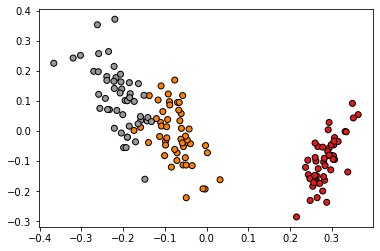

In [16]:
X_projected_em = project(X, mean, M_inv_em, W_em, sigma_em)
plt.scatter(X_projected_em[:, 0], X_projected_em[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')

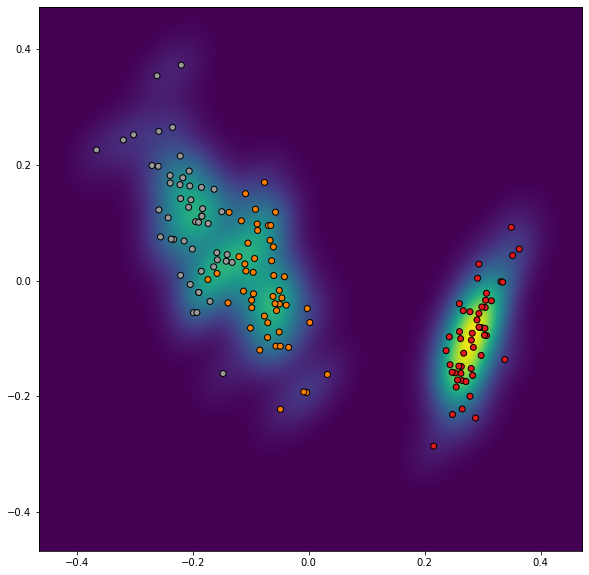

In [17]:
resolution = 200
margin = 0.1
x = y = np.linspace(X_projected_em.min()-margin,X_projected_em.max()+margin,resolution)
grid = np.dstack(np.meshgrid(x,y)).reshape(-1,2)

densities = np.array([space_likelihood(x, X, mean, M_inv_em, W_em, sigma_em) for x in tqdm(grid)]).reshape(resolution, resolution)
plt.figure(figsize=(10,10))
plt.imshow(densities, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X_projected_em[:, 0], X_projected_em[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')

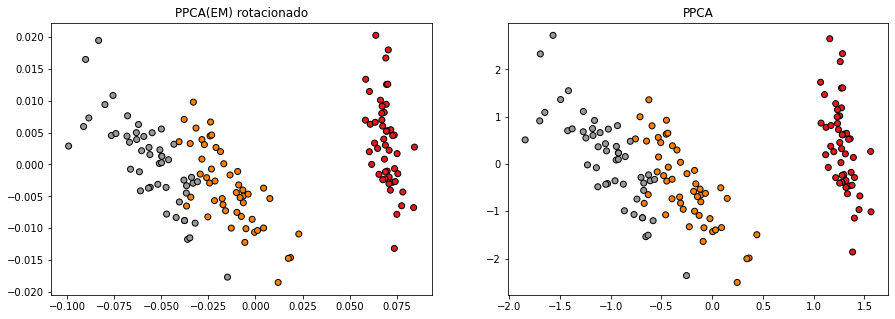

In [19]:
R = np.linalg.inv(W_em.T.dot(W_em)).dot(W_em.T).dot(W)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
X_rot = project(X, mean, M_inv_em, W_em, sigma_em).dot(R)
plt.scatter(X_rot[:, 0], X_rot[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
_ = plt.title(f"PPCA(EM) rotacionado")

plt.subplot(1,2,2)
X_projected = project(X, mean, M_inv, W, sigma)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
_ = plt.title("PPCA")